# Time Series Forecasting of BTC price


In this notebook I will be using different time series methods to predict the BTC price. BTC price dat had been obtained from this [dataset](https://www.kaggle.com/datasets/varpit94/bitcoin-data-updated-till-26jun2021).

I will be using three time series forecasting methods on this dat and compare their results. The three main methods are


1.   ARIMA
2.   Auto ARIMA
3.   LSTM with two layers



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
pd.__version__


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'1.3.5'

# Load data and initial analysis

Below are the key fields in the dataset:

__`Date, Open, High, Low, Close, Adj Close, Volume`__

In [ ]:
file_path = '/content/gdrive/My Drive/Capstone Project/Data/BTC-USD.csv'
btc_price = pd.read_csv(file_path)
btc_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747 entries, 0 to 2746
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2747 non-null   object 
 1   Open       2747 non-null   float64
 2   High       2747 non-null   float64
 3   Low        2747 non-null   float64
 4   Close      2747 non-null   float64
 5   Adj Close  2747 non-null   float64
 6   Volume     2747 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 150.4+ KB


In [ ]:
btc_price.sample(10)

,Date,Open,High,Low,Close,Adj Close,Volume
1757,2019-07-10,12571.537109,13129.529297,11710.978516,12156.512695,12156.512695,33627574244
149,2015-02-13,221.968994,240.259003,221.261993,235.427002,235.427002,42744400
1750,2019-07-03,10818.156250,11968.078125,10818.156250,11961.269531,11961.269531,30796494294
1153,2017-11-13,5938.250000,6811.189941,5844.290039,6559.490234,6559.490234,6263249920
2335,2021-02-07,39250.191406,39621.835938,37446.152344,38903.441406,38903.441406,65500641143
2070,2020-05-18,9675.695313,9906.030273,9570.359375,9726.575195,9726.575195,41827139896
1329,2018-05-08,9380.870117,9462.750000,9127.769531,9234.820313,9234.820313,7415869952
73,2014-11-29,376.152008,387.601013,372.144989,375.490997,375.490997,15375600
273,2015-06-17,250.822998,256.852997,246.475998,249.283997,249.283997,43858400
455,2015-12-16,465.208008,465.208008,443.851013,454.933990,454.933990,107944000


Seems like the data set does not have any missing values of nans. So we can start working on the dataframe.
Npw set the data as the index.

In [ ]:
btc_price.index = pd.to_datetime(btc_price['Date'])
btc_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2014-09-17,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [ ]:
btc_price.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2022-03-21,2022-03-21,41246.132813,41454.410156,40668.042969,41077.996094,41077.996094,24615543271
2022-03-22,2022-03-22,41074.105469,43124.707031,40948.281250,42358.808594,42358.808594,32004652376
2022-03-23,2022-03-23,42364.378906,42893.507813,41877.507813,42892.957031,42892.957031,25242943069
2022-03-24,2022-03-24,42886.652344,44131.855469,42726.164063,43960.933594,43960.933594,31042992291
2022-03-25,2022-03-25,43958.675781,44982.519531,43711.871094,44395.964844,44395.964844,30379415552


# Visualization

### Visualizing the High and Low prices of BTC

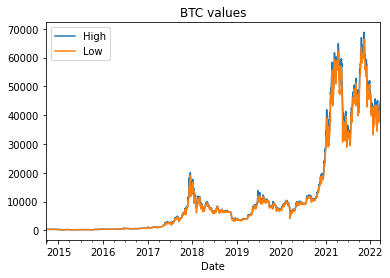

In [ ]:
dr = btc_price[['High', 'Low']]
dr.plot()
plt.title('BTC values');

####  Note: We are limiting our analysis on the open price of BTC.

### Auto-correlation plot with Lag 1

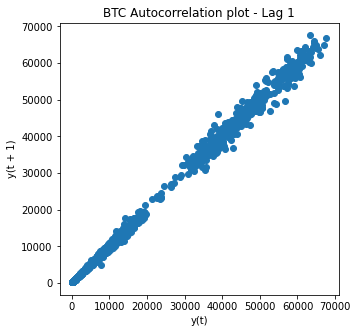

In [ ]:
from pandas.plotting import lag_plot

plt.figure(figsize=(5,5))
lag_plot(btc_price['Open'], lag=1)
plt.title('BTC Autocorrelation plot - Lag 1');


### Auto-Correlation plot with Lag 5 

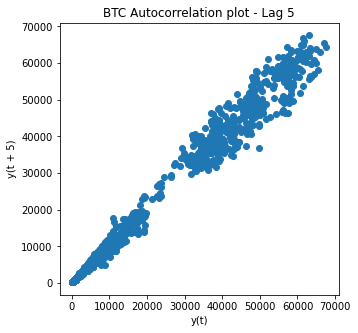

In [ ]:
plt.figure(figsize=(5,5))
lag_plot(btc_price['Open'], lag=5)
plt.title('BTC Autocorrelation plot - Lag 5');

There is a linear trend in the open prices of BTC.

## Build Train-Test Datasets

Lets seperate the data in to a traing and a test with 80/20 split.

In [ ]:
train_data, test_data = btc_price.iloc[0:int(len(btc_price)*0.8), :], btc_price.iloc[int(len(btc_price)*0.8):, :]

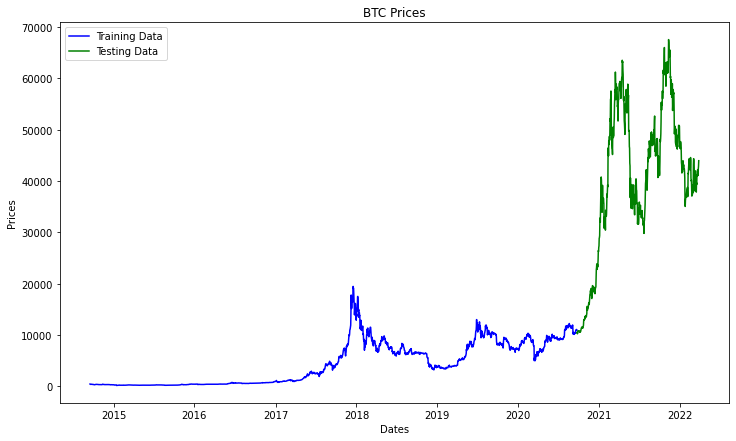

In [ ]:
plt.figure(figsize=(12,7))
plt.title('BTC Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data['Open'], 'blue', label='Training Data')
plt.plot(test_data['Open'], 'green', label='Testing Data')
plt.legend();

# Using the ARIMA Model

Here we try to find the p,d, and q values for the ARIMa odel for the BTC prices.


### Using Augmented Dickey-Fuller test to determine the stationarity of the data (Determine the d value)


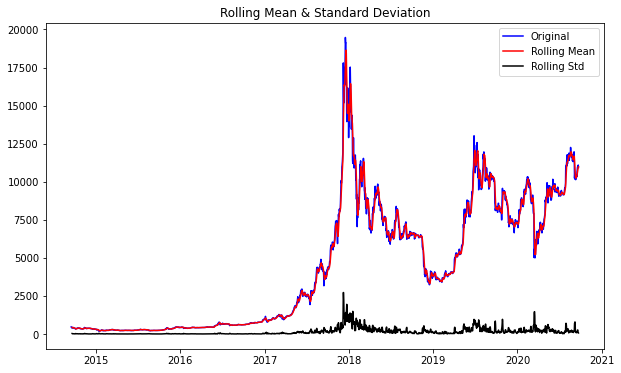

In [ ]:
window = 5
train_series = train_data['Open']

#Determing rolling statistics
rolmean = train_series.rolling(window).mean()
rolstd = train_series.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');
    

In [ ]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(train_series, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                   -1.695304
p-value                           0.433534
#Lags Used                       20.000000
Number of Observations Used    2176.000000
Critical Value (1%)              -3.433359
Critical Value (5%)              -2.862869
Critical Value (10%)             -2.567478
dtype: float64

The p-value is 0.433 which proves that our series is not stationary.
Let's Apply a first order differencing on the training data

In [ ]:
train_diff = train_series.diff(1)
train_diff = train_diff.dropna(inplace = False)


### Visualize Rolling statistics for differenced train data

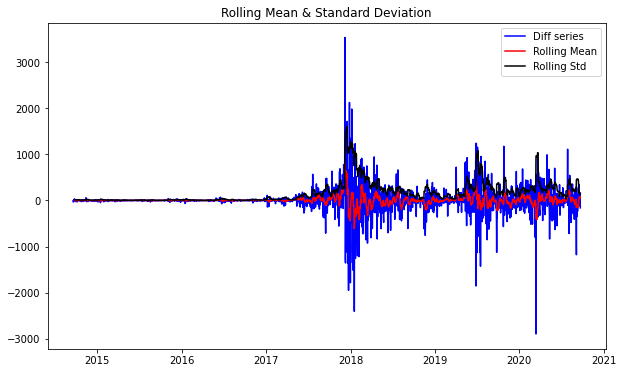

In [ ]:
#Plot rolling statistics:
window = 10


#Determing rolling statistics
rolmean = train_diff.rolling(window).mean()
rolstd = train_diff.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_diff, color='blue',label='Diff series')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

### Compute AD-Fuller Stats for differenced train data

In [ ]:
dftest = adfuller(train_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -9.061881e+00
p-value                        4.539916e-15
#Lags Used                     2.600000e+01
Number of Observations Used    2.169000e+03
Critical Value (1%)           -3.433368e+00
Critical Value (5%)           -2.862873e+00
Critical Value (10%)          -2.567480e+00
dtype: float64

After differencing, the p-value is extremely small. Thus this series is very likely to be stationary.

### Plot ACF and PACF on the original train series

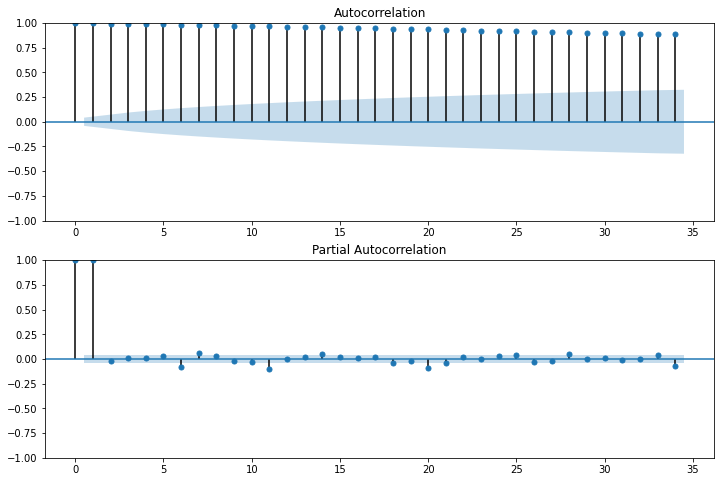

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_series, ax=ax[0]); # 
plot_pacf(train_series, ax=ax[1]);

### Plot ACF and PACF on the differenced train series

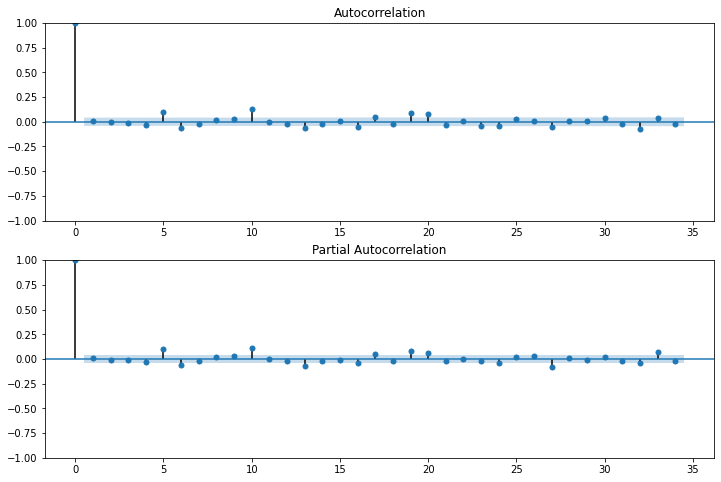

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_diff, ax=ax[0]); # 
plot_pacf(train_diff, ax=ax[1]);

# Determine p, d, q

It's easy to determine d. In our case, we see the first order differencing make the ts stationary. Hence d = 1


Hence:

- p=5
- d=1
- q=0

# Evaluation of ARIMA Model

In this section, the ARIMA model with the above p,d,q values will be evaluasated with the SMAPE values.

In [ ]:
# These lists are used to keep the KPI values for different methods
names=["ARIMA (5,1,0)"];
MSE=[];
SMAPE=[];

In [ ]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))

### Q8: Difference the Test Series

In [ ]:
test_series = test_data['Open']
test_diff = test_series.diff(1)
test_diff = test_diff.dropna(inplace = False)
#print(test_data)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [ ]:
#%%time 

history = [x for x in train_diff]

predictions = list()
for t in range(len(test_diff)):

    #call the ARIMA Method with history and params
    model = ARIMA(history,order=(5,1,0))  # initialize the model with history and right order of parameters
    model_fit = model.fit()  # fit the model
  

    output = model_fit.forecast()  # use forecast on the fitted model
    #print(output,t)
    yhat = output[0]
    predictions.append(yhat)

    obs = test_diff[t]
    history.append(obs)

    if t % 100 == 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))

Test Series Point: 0	Predicted=50.76724527709595, Expected=75.86816499999986
Test Series Point: 100	Predicted=974.6803036508167, Expected=152.43554700000095
Test Series Point: 200	Predicted=168.48695160426496, Expected=1592.453125
Test Series Point: 300	Predicted=-269.3455837220314, Expected=-961.7265629999965
Test Series Point: 400	Predicted=-654.6880230555757, Expected=-1881.269530999998
Test Series Point: 500	Predicted=-70.42593620893831, Expected=4352.214844000002


### Reverse Transform the forecasted values

This is very important. Since we used differencing of the first order in the series before training, we need to reverse transform the values to get meaningful price forecasts.

In [ ]:
reverse_test_diff = np.r_[test_series.iloc[0], test_diff].cumsum()
reverse_predictions = np.r_[test_series.iloc[0], predictions].cumsum()
reverse_test_diff.shape, reverse_predictions.shape

((550,), (550,))

### Evaluate model performance

In [ ]:
error = mean_squared_error(reverse_test_diff, reverse_predictions)
print('Testing Mean Squared Error: %.3f' % error)
MSE.append(error)
error2 = smape_kun(reverse_test_diff, reverse_predictions)
print('Symmetric Mean absolute percentage error: %.3f' % error2)
SMAPE.append(error2);

Testing Mean Squared Error: 7583865.188
Symmetric Mean absolute percentage error: 5.002


## Visualize the forecast results

In [ ]:
reverse_test_diff_series = pd.Series(reverse_test_diff)
reverse_test_diff_series.index = test_series.index

reverse_predictions_series = pd.Series(reverse_predictions)
reverse_predictions_series.index = test_series.index

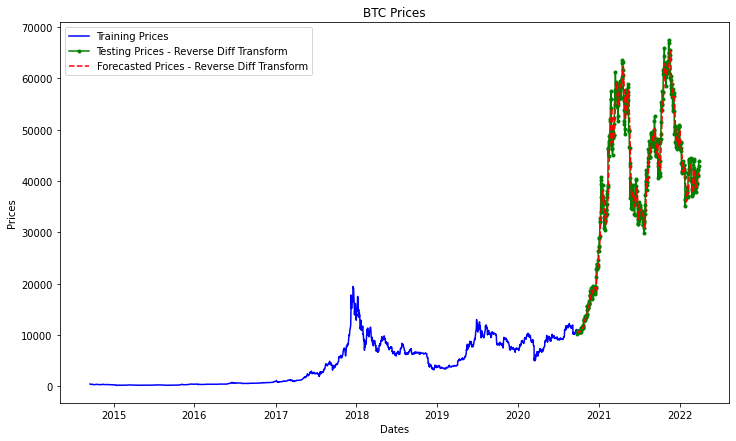

In [ ]:
plt.figure(figsize=(12,7))
plt.title('BTC Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_predictions_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

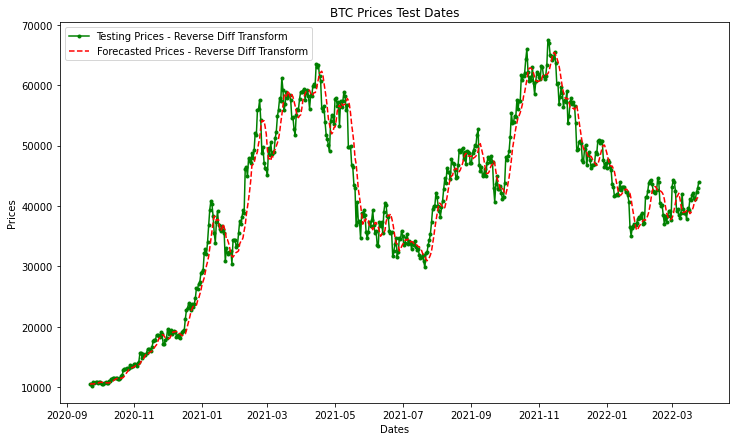

In [ ]:
plt.figure(figsize=(12,7))
plt.title('BTC Prices Test Dates')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_predictions_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

This analysis using ARIMA has performed pretty well in forecasting prices 

# Trying Auto ARIMA models


In [ ]:
#!pip install pmdarima
import pmdarima as pmd
names.append("Auto ARIMA")
autoarima_model = pmd.auto_arima(train_series, 
                              start_p=5, max_p=10,
                              start_q=1,max_q=5,
                              test="adf",
                              trace=True)

autoarima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=31036.634, Time=1.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=31053.916, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=31055.583, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=31055.582, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=31052.533, Time=0.03 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=31048.402, Time=1.25 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=31039.906, Time=0.44 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=31033.947, Time=1.67 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=31032.580, Time=0.51 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=31033.338, Time=0.57 sec
 ARIMA(7,1,1)(0,0,0)[0] intercept   : AIC=31032.641, Time=3.25 sec
 ARIMA(6,1,0)(0,0,0)[0]             : AIC=31031.200, Time=0.31 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=31038.451, Time=0.23 sec
 ARIMA(7,1,0)(0,0,0)[0]             : AIC=31031.986, Time=0.30 sec
 ARIMA(6,1,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2197
Model:              SARIMAX(10, 1, 0)   Log Likelihood              -15492.340
Date:                Thu, 01 Dec 2022   AIC                          31006.680
Time:                        14:45:20   BIC                          31069.318
Sample:                    09-17-2014   HQIC                         31029.571
                         - 09-21-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0163      0.008      2.166      0.030       0.002       0.031
ar.L2         -0.0040      0.009     -0.470      0.638      -0.021       0.013
ar.L3         -0.0095      0.010     -0.986      0.324      -0.028       0.009
ar.L4         -0.0281      0.009     -3.197      0.001      -0.045      -0.011
ar.L5          0.0888      0.010      9.034      0.000       0.070       0.108
ar.L6         -0.0597      0.009     -6.863      0.000      -0.077      -0.043
ar.L7         -0.0224      0.010     -2.233      0.026      -0.042      -0.003
ar.L8          0.0180      0.010      1.871      0.061      -0.001       0.037
ar.L9          0.0297      0.009      3.161      0.002       0.011       0.048
ar.L10         0.1130      0.010     11.180      0.000       0.093       0.133
sigma2      7.892e+04    708.676    111.358      0.000    7.75e+04    8.03e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             68622.67
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             570.40   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now us e the auto arima model we found to predict the results.




In [ ]:
history = [x for x in train_series]

auto_arima_predictions = list()
for t in range(len(test_series)):

    #call the ARIMA Method with history and params
    #model = ARIMA(history,order=(10,1,0))  # initialize the model with history and right order of parameters
    model_fit = autoarima_model.fit(history)  # fit the model
  

    output = model_fit.predict(n_periods=1)  # use forecast on the fitted model
    #print(output,t)
    yhat = output[0]
    auto_arima_predictions.append(yhat)

    obs = test_series[t]
    history.append(obs)

    if t % 100 == 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))



Test Series Point: 0	Predicted=10936.679769740293, Expected=10459.624023
Test Series Point: 100	Predicted=27315.855199021193, Expected=28841.574219
Test Series Point: 200	Predicted=58324.51627610624, Expected=58253.777344
Test Series Point: 300	Predicted=31317.405973214212, Expected=31800.011719
Test Series Point: 400	Predicted=62679.019470974745, Expected=60352.0
Test Series Point: 500	Predicted=37051.26662884357, Expected=37149.265625


In [ ]:
#autoarima_model.fit(train_series)
#auto_arima_predictions=autoarima_model.predict(n_periods=test_series.shape[0])
#print(len(auto_arima_predictions))
#reverse_test_diff = np.r_[test_series.iloc[0], test_diff].cumsum()
#auto_arima_everse_predictions = np.r_[test_series.iloc[0], auto_arima_predictions].cumsum()


#print(len(test_series))
#print(len(auto_arima_everse_predictions))
'''
error = mean_squared_error(reverse_test_diff, auto_arima_everse_predictions)
print('Auto ARIMA Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(reverse_test_diff, auto_arima_everse_predictions)
print('Auto ARIMA Symmetric Mean absolute percentage error: %.3f' % error2)

'''
error = mean_squared_error(test_series, auto_arima_predictions)
print('Auto ARIMA Testing Mean Squared Error: %.3f' % error)
MSE.append(error)
error2 = smape_kun(test_series, auto_arima_predictions)
print('Auto ARIMA Symmetric Mean absolute percentage error: %.3f' % error2)
SMAPE.append(error2)


auto_arima_predictions_series = pd.Series(auto_arima_predictions)
auto_arima_predictions_series.index = test_series.index

Auto ARIMA Testing Mean Squared Error: 2932841.658
Auto ARIMA Symmetric Mean absolute percentage error: 2.915


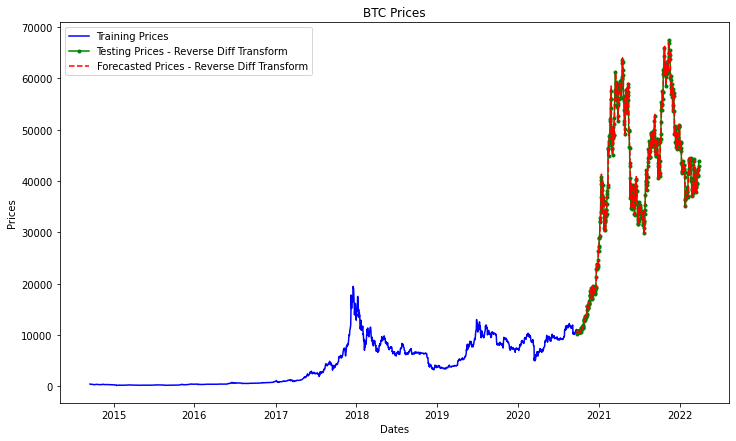

In [ ]:
plt.figure(figsize=(12,7))
plt.title('BTC Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(test_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(auto_arima_predictions_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

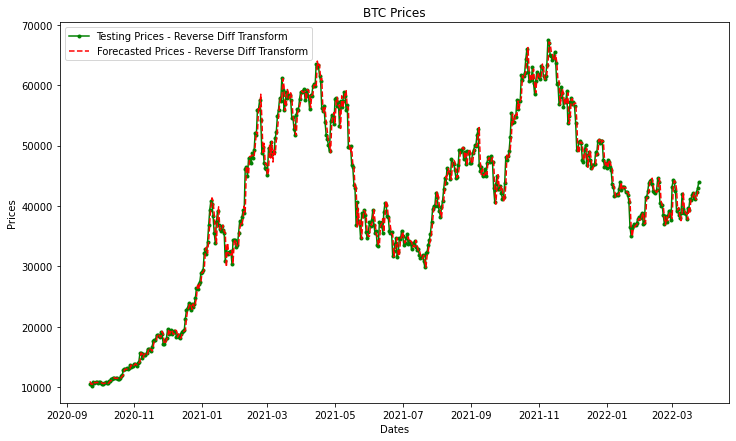

In [ ]:
plt.figure(figsize=(12,7))
plt.title('BTC Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(auto_arima_predictions_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

# Time Series Forecasting with Deep Learning

Here we use LSTM for time series prediction.

In [ ]:
# Let's load the libraries and dependencies for the deep learning model
from sklearn.preprocessing import MinMaxScaler

#%tensorflow_version 1.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

## Build Train-Test Datasets

In [ ]:
# Splitting the train and test set considering 'Open' feature from the dataset
train_data, test_data = btc_price.iloc[0:int(len(btc_price)*0.8), :], btc_price.iloc[int(len(btc_price)*0.8):, :]
train_series = train_data['Open']
test_series = test_data['Open']
train_series.shape, test_series.shape

((2197,), (550,))

### Scaling
As stock prices can vary across a wide range, we scale the data to have zero mean and unit variance. This is done to ensure that the gradient descent is sooner when learning a deep learning model

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(train_data[['Open']])

### Train Data Preparation

Train data uses the previous 60 days (two months) data to predict the stock price of the next day.
The data is prepared just like a sliding window approach, where
*window_size = 60*


In [ ]:
#1 output and 60 values inputs
# So for each element of training set (output), we have 60 previous training set elements (input)
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((2137, 60), (2137,))

#### Reshape X_train



In [ ]:
# Reshaping X_train for efficient modeling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))
X_train.shape

(2137, 60, 1)

### LSTM Regression model

We use  [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM):
*   units - output dimensions
*   return_sequences is set to True to get all the hidden state vectors information

The model uses 2 LSTM layers followed by a Dense Layer with a single neuron to output regression prediction.

### Building the LSTM based forecasting DL Model architecture


In [ ]:
names.append("LSTM")

regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=64, return_sequences=True,input_shape=(64,1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=64, return_sequences=False,input_shape=(64,1)))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN - optimizer(rmsprop)and loss(mean squared error)

regressor.compile(optimizer='rmsprop',loss='mse')
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 6

### Train the model

In [ ]:
regressor.fit(X_train,y_train, epochs=15, batch_size=64, validation_split=0.1, shuffle=False)

Epoch 1/15
31/31 [==============================] - 11s 192ms/step - loss: 0.0214 - val_loss: 0.0032
Epoch 2/15
31/31 [==============================] - 4s 145ms/step - loss: 0.0095 - val_loss: 0.0026
Epoch 3/15
31/31 [==============================] - 4s 141ms/step - loss: 0.0131 - val_loss: 0.0025
Epoch 4/15
31/31 [==============================] - 4s 143ms/step - loss: 0.0076 - val_loss: 0.0036
Epoch 5/15
31/31 [==============================] - 4s 145ms/step - loss: 0.0094 - val_loss: 0.0030
Epoch 6/15
31/31 [==============================] - 5s 147ms/step - loss: 0.0065 - val_loss: 0.0025
Epoch 7/15
31/31 [==============================] - 4s 145ms/step - loss: 0.0086 - val_loss: 0.0026
Epoch 8/15
31/31 [==============================] - 5s 147ms/step - loss: 0.0064 - val_loss: 0.0023
Epoch 9/15
31/31 [==============================] - 5s 147ms/step - loss: 0.0060 - val_loss: 0.0025
Epoch 10/15
31/31 [==============================] - 4s 145ms/step - loss: 0.0069 - val_loss: 0.002

### Test Data Forecasting



In [ ]:
train_last60 = train_series[-60:]
print(train_last60.shape)
test_series.shape

(60,)


(550,)

### Combine both train_last60 and test_series together 



In [ ]:
new_test_series =  pd.concat([train_last60,test_series],axis=0)
print(new_test_series.shape)


(610,)


In [ ]:
test_set_scaled = sc.fit_transform(new_test_series.values.reshape(-1,1))

### Prepare Test dataset Windows of 60  days each

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len(test_set_scaled)):
    X_test.append(test_set_scaled[i-60:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(550, 60, 1)

### Model Prediction and Reverse Transform of Prices

In [ ]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price_revtrans = sc.inverse_transform(predicted_stock_price).ravel()
predicted_stock_price_revtrans_series = pd.Series(predicted_stock_price_revtrans)
predicted_stock_price_revtrans_series.index = test_series.index
predicted_stock_price_revtrans_series.shape, test_series.shape

18/18 [==============================] - 2s 32ms/step


((550,), (550,))

## Model Evaluation

In [ ]:
# Evaluating our model
error = mean_squared_error(test_series, predicted_stock_price_revtrans_series)
print('Testing Mean Squared Error: %.3f' % error)
MSE.append(error)
error2 = smape_kun(test_series, predicted_stock_price_revtrans_series)
print('Symmetric Mean absolute percentage error: %.3f' % error2)
SMAPE.append(error2)

Testing Mean Squared Error: 24110388.231
Symmetric Mean absolute percentage error: 8.727


## Visualizing the results from model predictions

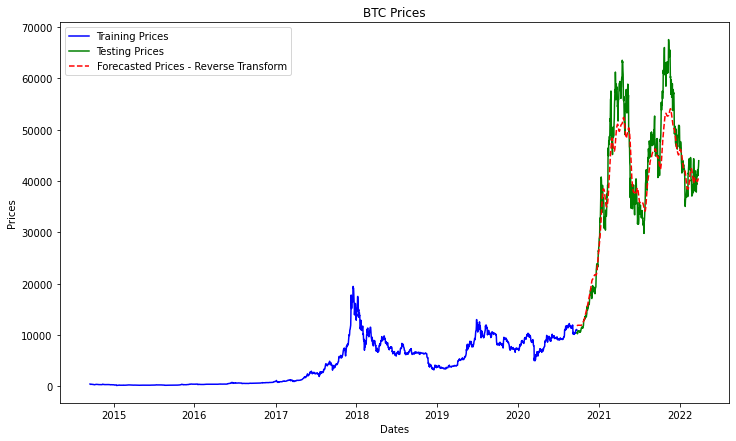

In [ ]:
plt.figure(figsize=(12,7))
plt.title('BTC Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(test_series, color='green', label='Testing Prices')
plt.plot(predicted_stock_price_revtrans_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Transform')
plt.legend();

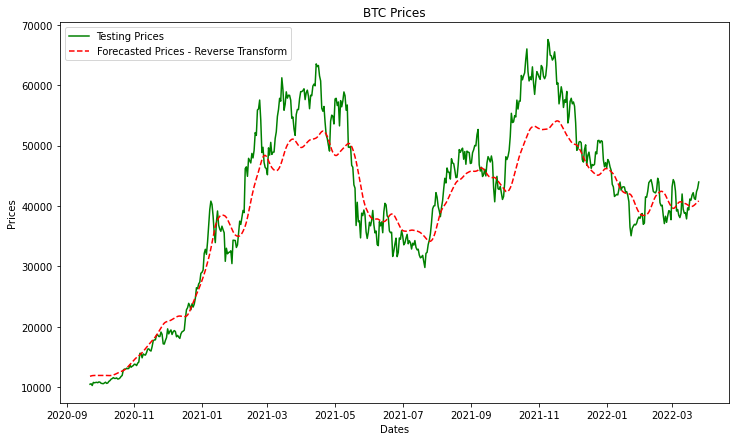

In [ ]:
plt.figure(figsize=(12,7))
plt.title('BTC Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(test_series, color='green', label='Testing Prices')
plt.plot(predicted_stock_price_revtrans_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Transform')
plt.legend();

## Using FB Prophet

In [ ]:
#!pip install prophet

import prophet

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
df_train = pd.DataFrame()

df_train['ds'] = train_data.index
df_train['y'] = train_data['Open'].values


df_test = pd.DataFrame()

df_test['ds'] = test_data.index
df_test['y'] = test_data['Open'].values

prophet_predictions=[];

model=prophet.Prophet()
model.fit(df_train)  # fit the model

future = model.make_future_dataframe(len(df_test), freq='d')
forecast=model.predict(future)
print(forecast)
yhat=forecast.iloc[:,-1]
prophet_predictions.append(yhat)


'''
auto_arima_predictions = list()
for t in range(len(test_series)):

    #call the ARIMA Method with history and params
    #model = ARIMA(history,order=(10,1,0))  # initialize the model with history and right order of parameters
    model=prophet.Prophet()
    model.fit(df_train)  # fit the model
  
    future = model.make_future_dataframe(1, freq='d')
    df_train=df_train.append({'ds':df_test.iloc[t,0],'y':df_test.iloc[t,1]}, ignore_index=True)
    forecast=model.predict(future)
    print(forecast)
    yhat=forecast.iloc[-1,-1]
    prophet_predictions.append(yhat)
   
    output = model_fit.predict(n_periods=1)  # use forecast on the fitted model
    #print(output,t)
    yhat = output[0]
    auto_arima_predictions.append(yhat)

    obs = test_series[t]
    history.append(obs)
   
    if t % 10 == 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, df_test.iloc[t,1]))
'''


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpan3zqtm3/3urosyod.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpan3zqtm3/rkkjz0ue.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70286', 'data', 'file=/tmp/tmpan3zqtm3/3urosyod.json', 'init=/tmp/tmpan3zqtm3/rkkjz0ue.json', 'output', 'file=/tmp/tmpan3zqtm3/prophet_model1ihi4am5/prophet_model-20221201145136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:51:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:51:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


             ds        trend   yhat_lower    yhat_upper  trend_lower  \
0    2014-09-17   512.147343  -570.647763   2069.838257   512.147343   
1    2014-09-18   511.340896  -621.478315   1921.593939   511.340896   
2    2014-09-19   510.534449  -578.884573   2028.640073   510.534449   
3    2014-09-20   509.728001  -726.058919   1948.143607   509.728001   
4    2014-09-21   508.921554  -585.995482   2038.154519   508.921554   
...         ...          ...          ...           ...          ...   
2742 2022-03-21  9962.438964 -5232.489348  21789.797421 -4078.956405   
2743 2022-03-22  9963.654444 -5101.683005  21864.726626 -4108.607107   
2744 2022-03-23  9964.869924 -5148.405364  21415.591512 -4138.257808   
2745 2022-03-24  9966.085403 -5192.737719  21497.120982 -4167.908510   
2746 2022-03-25  9967.300883 -5044.129864  21570.405113 -4197.559212   

       trend_upper  additive_terms  additive_terms_lower  \
0       512.147343      281.683914            281.683914   
1       511.340

"\nauto_arima_predictions = list()\nfor t in range(len(test_series)):\n\n    #call the ARIMA Method with history and params\n    #model = ARIMA(history,order=(10,1,0))  # initialize the model with history and right order of parameters\n    model=prophet.Prophet()\n    model.fit(df_train)  # fit the model\n  \n    future = model.make_future_dataframe(1, freq='d')\n    df_train=df_train.append({'ds':df_test.iloc[t,0],'y':df_test.iloc[t,1]}, ignore_index=True)\n    forecast=model.predict(future)\n    print(forecast)\n    yhat=forecast.iloc[-1,-1]\n    prophet_predictions.append(yhat)\n   \n    output = model_fit.predict(n_periods=1)  # use forecast on the fitted model\n    #print(output,t)\n    yhat = output[0]\n    auto_arima_predictions.append(yhat)\n\n    obs = test_series[t]\n    history.append(obs)\n   \n    if t % 10 == 0:\n      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, df_test.iloc[t,1]))\n"

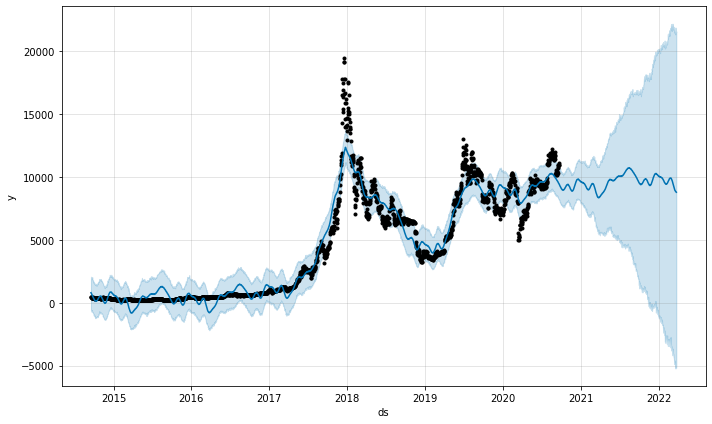

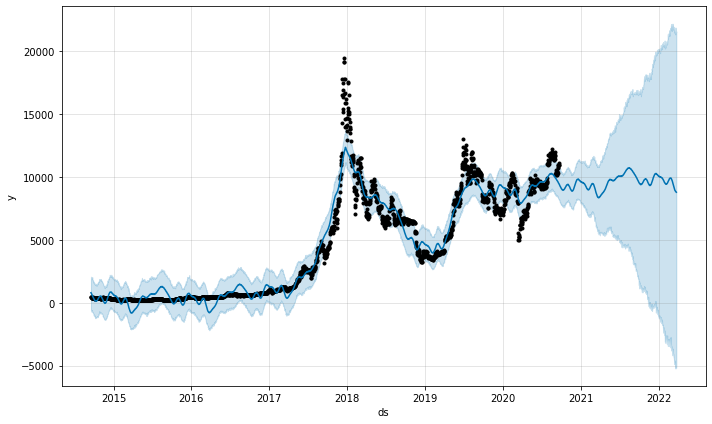

In [ ]:
model.plot(forecast)

In [ ]:
#print(forecast)
#print(forecast.iloc[-552:,-1])
prophet_predictions=forecast.iloc[-550:,-1]
names.append('Prophet')
print(test_series.shape)
print(len(prophet_predictions))
error = mean_squared_error(test_series, prophet_predictions)
print('Prophet Mean Squared Error: %.3f' % error)
MSE.append(error)
error2 = smape_kun(test_series, prophet_predictions)
print('Prophet Symmetric Mean absolute percentage error: %.3f' % error2)
SMAPE.append(error2)


prophet_predictions_series = pd.Series(prophet_predictions)
prophet_predictions_series.index = test_series.index

(550,)
550
Prophet Mean Squared Error: 1176769082.719
Prophet Symmetric Mean absolute percentage error: nan


## Summary of results

Now lets look how our three methods preformed on the test data set. We'll combine the lists with the KPI results into a data fraem for comaprison.

In [ ]:
prophet_predictions

Date
2020-09-22    9409.311029
2020-09-23    9362.950252
2020-09-24    9329.929730
2020-09-25    9280.042648
2020-09-26    9257.343000
                 ...     
2022-03-21    8844.022694
2022-03-22    8839.278721
2022-03-23    8810.450026
2022-03-24    8801.143464
2022-03-25    8780.728976
Name: yhat, Length: 550, dtype: float64

In [ ]:
temp={"Method":names,"MSE":MSE,"SMAPE":SMAPE}
results=pd.DataFrame(temp)
results.head()

,Method,MSE,SMAPE
0,"ARIMA (5,1,0)",7.583865e+06,5.002120
1,Auto ARIMA,2.932842e+06,2.914987
2,LSTM,2.411039e+07,8.727481
3,Prophet,1.176769e+09,NaN


According to the above dataframe, Autio ARIMA with parametrs (10,1,0) performde best with a SMAPE of 2.9 while ARIMA with manual p,d,q values had a SMAPE of 5. LSTM had the lowest performance with SMAPE of 11.8.